In [2]:
pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=aa2124f632776f1142d33990335578004e812c643ac65a9605eea1ae698d8207
  Stored in directory: /root/.cache/pip/wheels/26/af/8b/fac1b47dffef567f945641cdc9b67bb25fae5725d462a8cf81
  Created wheel for multitasking: filename=multitasking-0.0.9-py3-none-any.whl size=8368 sha256=027f1cd8f2c9ff1e91ec42c136ef98ff34fef4a6a0efc167fcaa85444ed0aa5a
  Stored in directory: /root/.cache/pip/wheels/ae/25/47/4d68431a7ec1b6c4b5233365934b74c1d4e665bf5f968d363a
Successfully built yfinance multitasking
Note: you may need to restart the kernel to use updated packages.


In [3]:
import yfinance as yf

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [283]:
data = yf.download('ESCORTS.NS',period='5y',interval='1d')

[*********************100%***********************]  1 of 1 completed


In [284]:
data.head(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-06-22,185.000000,210.399994,185.000000,207.649994,204.559860,21562785
2016-06-23,208.050003,214.000000,202.899994,204.350006,201.308975,7565731
2016-06-24,192.000000,211.899994,185.550003,209.550003,206.431580,7160036


In [285]:
data_target = data.iloc[:1182,4]
data_test = data.iloc[1132:,4]
data = data.loc[:,["Adj Close"]].values

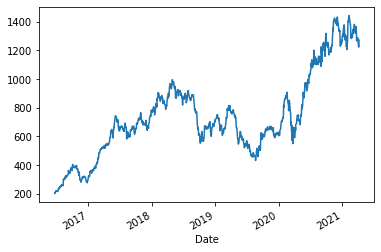

In [286]:
plot = data_target.plot()

In [287]:
#Check Length 
print("Length of Data:{}".format(len(data)))
print("Length of Data_Target:{}".format(len(data_target)))

Length of Data:1232
Length of Data_Target:1182


In [288]:
#Scaling Dataset
def scaledata(data_target):
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0,1))
    data_target_scaled = scaler.fit_transform(np.array(data_target).reshape(-1,1))
    #plot_scaled = pd.DataFrame(data_target_scaled).plot()
    print(data_target.shape)
    return data_target_scaled, scaler

In [289]:
data_target_scaled = scaledata(data_target)[0]
scaler = scaledata(data_target)[1]
data_target_scaled

(1182,)
(1182,)


array([[0.00261938],
       [0.        ],
       [0.0041275 ],
       ...,
       [0.82245463],
       [0.83683711],
       [0.86169425]])

In [290]:
data_test_scaled = scaledata(data_test)[0]

(100,)


In [291]:
#Create pattern and end price set
def createPatternSet(data_target_scaled,steps=7):   
    x_patern = []
    y_price = []

    for day in range(steps,data_target_scaled.shape[0]):
        row = data_target_scaled[day-steps:day,0]
        #print(len(row))
        x_patern.append(row)
        y = data_target_scaled[day,0]
        #print(y)
        y_price.append(y)
    
    x_patern,y_price = np.array(x_patern),np.array(y_price)
    x_patern = x_patern.reshape(x_patern.shape[0],x_patern.shape[1],1)
    
    return x_patern,y_price

In [292]:
train_pattern = createPatternSet(data_target_scaled,steps=50)

In [293]:
x_train = train_pattern[0]
y_train = train_pattern[1]

In [294]:
x_train.shape

(1132, 50, 1)

In [295]:
y_train.shape

(1132,)

In [296]:
x_train

array([[[0.00261938],
        [0.        ],
        [0.0041275 ],
        ...,
        [0.09671871],
        [0.09612338],
        [0.10005241]],

       [[0.        ],
        [0.0041275 ],
        [0.01107284],
        ...,
        [0.09612338],
        [0.10005241],
        [0.10171932]],

       [[0.0041275 ],
        [0.01107284],
        [0.01174752],
        ...,
        [0.10005241],
        [0.10171932],
        [0.10275118]],

       ...,

       [[0.88989525],
        [0.87369984],
        [0.88018601],
        ...,
        [0.8754322 ],
        [0.86435324],
        [0.83317094]],

       [[0.87369984],
        [0.88018601],
        [0.82555671],
        ...,
        [0.86435324],
        [0.83317094],
        [0.82245463]],

       [[0.88018601],
        [0.82555671],
        [0.84263842],
        ...,
        [0.83317094],
        [0.82245463],
        [0.83683711]]])

In [297]:
class StocksPriceRNN():

    loss='mean_squared_error'
    batch_size=32
    neurons = 50
    model = tf.keras.Sequential()
    def __init__(self,x_train,y_train,epoch):
        self.x_train = x_train
        self.y_train = y_train
        self.epoch = epoch
    
    def buildArchitecture(self,rnn=2,dense=1):
        StocksPriceRNN.model = tf.keras.Sequential()
        StocksPriceRNN.model.add(tf.keras.layers.SimpleRNN(StocksPriceRNN.neurons,
                                            activation='tanh',
                                            return_sequences = True,
                                            input_shape = (self.x_train.shape[1],1)))
        StocksPriceRNN.model.add(tf.keras.layers.Dropout(0.2))
        for i in range(rnn):
            StocksPriceRNN.model.add(tf.keras.layers.SimpleRNN(StocksPriceRNN.neurons,
                                                activation='tanh',
                                                return_sequences = True))
            StocksPriceRNN.model.add(tf.keras.layers.Dropout(0.2))
        
        #return sequense changed to false
        StocksPriceRNN.model.add(tf.keras.layers.SimpleRNN(StocksPriceRNN.neurons,
                                                activation='tanh',
                                                return_sequences = False))
        StocksPriceRNN.model.add(tf.keras.layers.Dropout(0.2))
        
        for i in range(dense):
            StocksPriceRNN.model.add(tf.keras.layers.Dense(units=StocksPriceRNN.neurons,
                                            activation='tanh'))
        
        #Output
        StocksPriceRNN.model.add(tf.keras.layers.Dense(units=1))
        return StocksPriceRNN.model.summary()
    
    def compiler(self):
        opt= tf.keras.optimizers.Adam()
        StocksPriceRNN.model.compile(optimizer = opt,
                                    loss = StocksPriceRNN.loss)
        return StocksPriceRNN.model.summary()
        
    def modelfit(self):
        history = StocksPriceRNN.model.fit(self.x_train,self.y_train,
                                        epochs=self.epoch,batch_size=StocksPriceRNN.batch_size,validation_split=0.2,
                                       )
        return history
    
    def changeBatchSize(self,size):
        StocksPriceRNN.batch_size = size
        print("Changed!")
    def changeNeurons(self,size):
        StocksPriceRNN.neurons = size
        print("Changed!")
    def changeEpoch(self,size):
        self.epoch = size
        print("Changed!")

In [ ]:
RNN1 = StocksPriceRNN(x_train,y_train,50)

In [ ]:
RNN1.buildArchitecture(2,0)

In [ ]:
RNN1.compiler()

In [ ]:
history = RNN1.modelfit()

In [298]:
#Prepare Test Data
test = data[len(data) - len(data_test) - 50:]
test = scaler.transform(test)

In [ ]:
test_pattern = createPatternSet(test,steps=50)
x_test = test_pattern[0]
y_test = test_pattern[1]

In [ ]:
#Predict the value for test set
y_test

In [ ]:
x_test

In [ ]:
pred = RNN1.model.predict(x=x_test)
pred.shape

In [ ]:
#Transform back the inverse value

output = scaler.inverse_transform(pred)
org_vals = scaler.inverse_transform(y_test.reshape(-1,1))

In [ ]:
output

In [299]:
def plotting(org_vals,output):
    plt.figure(figsize=(10,5), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(org_vals,color="Green",label="Org value")
    plt.plot(output,color="Yellow",label="Predicted")
    plt.legend()
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.grid(True)
    plt.show()

In [ ]:
plotting(org_vals,output)

In [ ]:
#Build a for loop with some iterations
for steps in [7,30,90]:
    for epoch in [20,30,50]:
        #prepare train data
        train_pattern = createPatternSet(data_target_scaled,steps=steps)
        #prepare test data
        test = data[len(data) - len(data_test) - steps:]
        test = scaler.transform(test)

        test_pattern = createPatternSet(test,steps=steps)
        x_test = test_pattern[0]
        y_test = test_pattern[1]
        #Build Model
        RNN1 = StocksPriceRNN(x_train,y_train,epoch)
        RNN1.buildArchitecture(2,0)
        RNN1.compiler()
        #fit model
        history = RNN1.modelfit()
        #Predict Values
        pred = RNN1.model.predict(x=x_test)
        output = scaler.inverse_transform(pred)
        
        #visualise
        print("Plotting for Steps {} and Epoch {}".format(steps,epoch))
        plotting(org_vals,output)

In [300]:
#Long Short Term Memory
class LstmModel(StocksPriceRNN):
    StocksPriceRNN.model = tf.keras.Sequential()
    def __init__(self,x_train,y_train,epoch):
        super().__init__(x_train,y_train,epoch)
    
    def buildArchitecture(self,dense=1):
        StocksPriceRNN.model = tf.keras.Sequential()
        StocksPriceRNN.model.add(tf.keras.layers.LSTM(StocksPriceRNN.neurons,input_shape=(None,1)))
        #Output
        StocksPriceRNN.model.add(tf.keras.layers.Dense(units=1))
        return StocksPriceRNN.model.summary()

In [ ]:
LSTM = LstmModel(x_train,y_train,epoch=50)

In [ ]:
LSTM.changeBatchSize(1)

In [ ]:
LSTM.changeNeurons(10)

In [ ]:
LSTM.buildArchitecture()

In [ ]:
LSTM.compiler()

In [ ]:
history = LSTM.modelfit()

In [ ]:
pred = LSTM.model.predict(x_test)
output = scaler.inverse_transform(pred)

plotting(org_vals,output)

In [301]:
#27 Iterations!!!!!!!!!!!!!!!!!!!
for epch in [60,100,200]:
    for batch in [2,4,6]:
        for neurons in [8,10,12]:
            LSTM2 = LstmModel(x_train,y_train,epoch=epch)
            LSTM2.changeBatchSize(batch)
            LSTM2.changeNeurons(neurons)

            LSTM2.buildArchitecture()
            LSTM2.compiler()
            history = LSTM2.modelfit()

            pred = LSTM2.model.predict(x_test)
            output = scaler.inverse_transform(pred)
            

            print("For epch {} and batch {}".format(epch,batch))
            plotting(org_vals,output)

Changed!
Changed!
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
453/453

KeyboardInterrupt: 

### Conclusion:
- Lstm with batch 2 and units 10 works best with epoch 200. Model was able to capture the actual path with minimum deviations in it.

Changed!
Changed!
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
453/45

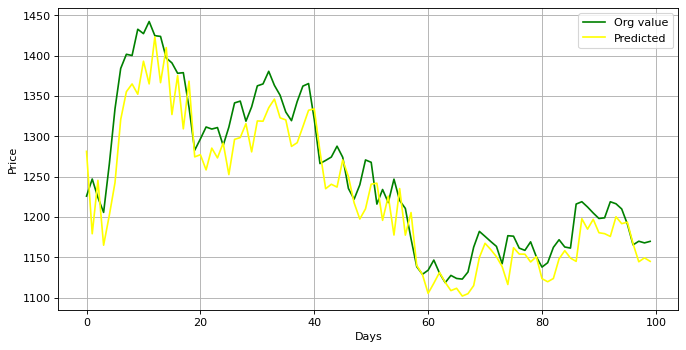

In [302]:
import warnings
warnings.filterwarnings('ignore')

#Final Model Output
#prepare train data
train_pattern = createPatternSet(data_target_scaled,steps=90)
test = data[len(data) - len(data_test) - 90:]
test = scaler.transform(test)
test_pattern = createPatternSet(test,steps=90)
x_test = test_pattern[0]
y_test = test_pattern[1]
LSTM2 = LstmModel(x_train,y_train,epoch=200)
LSTM2.changeBatchSize(2)
LSTM2.changeNeurons(10)

LSTM2.buildArchitecture()
LSTM2.compiler()
history = LSTM2.modelfit()
pred = LSTM2.model.predict(x_test)
pred = scaler.inverse_transform(pred)
org_vals = scaler.inverse_transform(y_test.reshape(-1,1))
print("For epch {}, neurons {} and batch {}".format(200,10,2))
plotting(org_vals,pred)

# Future Predictions

In [306]:
curr_data = yf.download('ESCORTS.NS',start="2021-02-1",end="2021-06-22",interval='1d')
print("Length of Data: ",len(curr_data))
curr_data = curr_data["Adj Close"]

def futurePrediciton1D(curr_data,start="2021-02-1",end="2021-06-19"):
    '''
    '''
    curr_scaled = scaledata(curr_data)[0]
    scaler = scaledata(curr_data)[1]
    
    #flatten into list
    x_data = list(curr_scaled.flatten())
    #convert into 3D
    x_data = np.array(x_data)
    x_data = x_data.reshape(1,len(x_data),1)
    
    #Predict
    nextDay = LSTM2.model.predict(x=x_data)
    nextDay = scaler.inverse_transform(nextDay.reshape(-1,1))

    nextDay = nextDay[-1][0]
    print("Prediction: {}".format(nextDay))
    
    #convert into dataframe again
    curr_data = pd.DataFrame(curr_data)
    curr_data.reset_index(inplace=True)
    adj_cl = curr_data[['Adj Close']]
    
    #concatenate new value
    adj_cl.loc[len(adj_cl.index)] = [nextDay]
    
    return adj_cl

[*********************100%***********************]  1 of 1 completed
Length of Data:  95


(95,)
(95,)
Prediction: 1170.62060546875


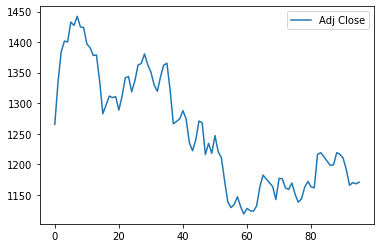

In [307]:
data = futurePrediciton1D(curr_data)
plot = data.plot()